In [ ]:
#  Install Dependencies
!pip install imbalanced-learn openpyxl librosa --quiet


In [2]:
#  Import Libraries
import numpy as np, pandas as pd, librosa, ast, joblib, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import warnings, os
warnings.filterwarnings("ignore")


In [3]:
# Load and preprocess dataset
df = pd.read_excel("/content/sample_data/full_balanced_dataset_merged.xlsx")
df.columns = [col.strip().lower() for col in df.columns]
df.dropna(subset=["student mfcc", "teacher mfcc", "labels"], inplace=True)

def parse_mfcc(s):
    try: return np.array(ast.literal_eval(s))
    except: return np.array([])

df["student mfcc"] = df["student mfcc"].apply(parse_mfcc)
df["teacher mfcc"] = df["teacher mfcc"].apply(parse_mfcc)
df = df[(df["student mfcc"].apply(len) > 0) & (df["teacher mfcc"].apply(len) > 0)]

X_raw = np.stack([np.concatenate([s, t]) for s, t in zip(df["student mfcc"], df["teacher mfcc"])]).astype(np.float32)
y_raw = df["labels"].str.strip()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)


In [4]:
# Build and train autoencoder for dimensionality reduction
input_dim = X_scaled.shape[1]
inp = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inp)
x = Dense(64, activation='relu')(x)
bottleneck = Dense(16, activation='relu')(x)
x = Dense(64, activation='relu')(bottleneck)
x = Dense(128, activation='relu')(x)
out = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=30, batch_size=32, verbose=0)

encoder_model = Model(inp, bottleneck)
X_compressed = encoder_model.predict(X_scaled)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



========= Split: 80-20 =========
SVM (Without SMOTE)

 SVM 80-20 No SMOTE (Train)
Accuracy: 0.6771689497716895
Precision: 0.7179749590320893
Recall: 0.6771689497716895
F1 Score: 0.639867929042599


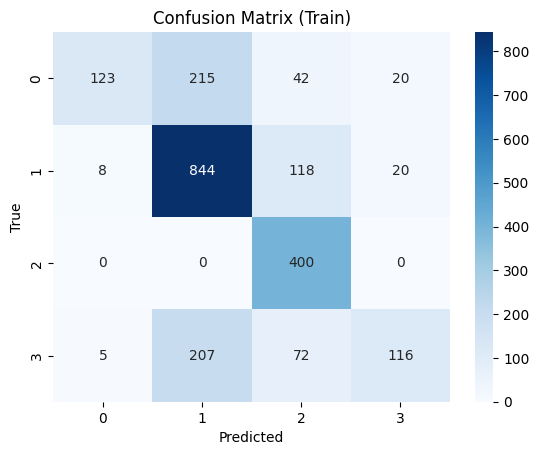


 SVM 80-20 No SMOTE (Test)
Accuracy: 0.6386861313868614
Precision: 0.6627302313396947
Recall: 0.6386861313868614
F1 Score: 0.5883899525717889


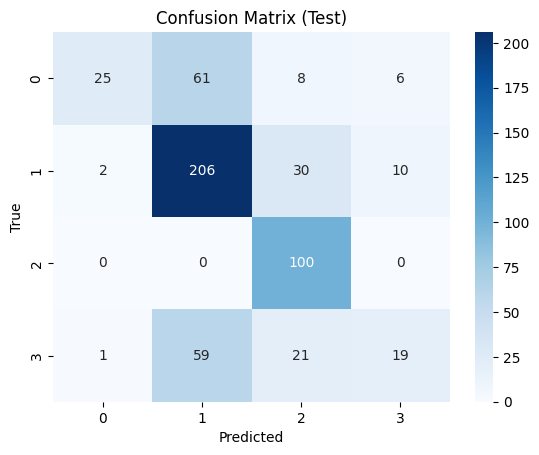

SVM (With SMOTE)

 SVM 80-20 SMOTE (Train)
Accuracy: 0.7065656565656566
Precision: 0.7050055919778696
Recall: 0.7065656565656566
F1 Score: 0.6974459176149392


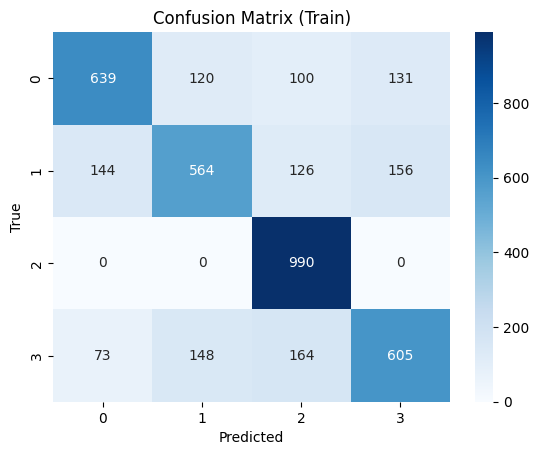


 SVM 80-20 SMOTE (Test)
Accuracy: 0.6113138686131386
Precision: 0.6287785690392124
Recall: 0.6113138686131386
F1 Score: 0.6066219978292091


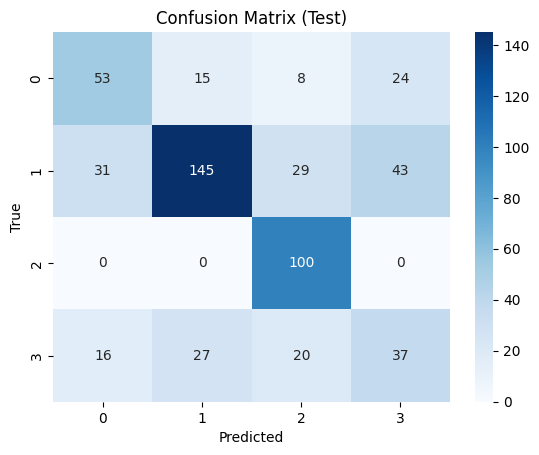


========= Split: 70-30 =========
SVM (Without SMOTE)

 SVM 70-30 No SMOTE (Train)
Accuracy: 0.6711899791231732
Precision: 0.7200005968358996
Recall: 0.6711899791231732
F1 Score: 0.6306516207055051


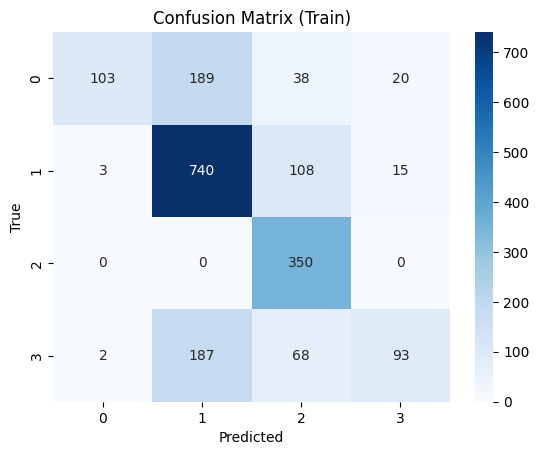


 SVM 70-30 No SMOTE (Test)
Accuracy: 0.6459854014598541
Precision: 0.6679790550037792
Recall: 0.6459854014598541
F1 Score: 0.5895934644984566


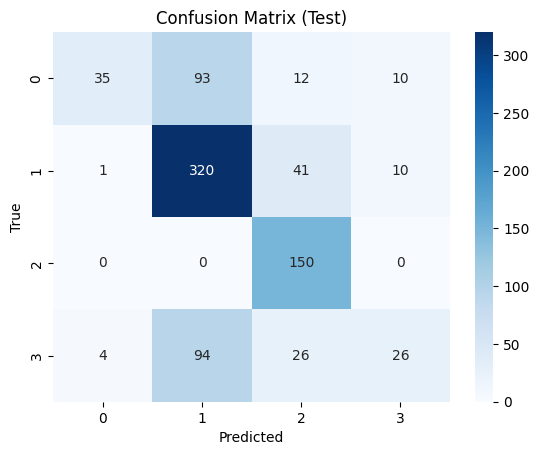

SVM (With SMOTE)

 SVM 70-30 SMOTE (Train)
Accuracy: 0.6893764434180139
Precision: 0.6881597240457884
Recall: 0.6893764434180139
F1 Score: 0.6790966714257926


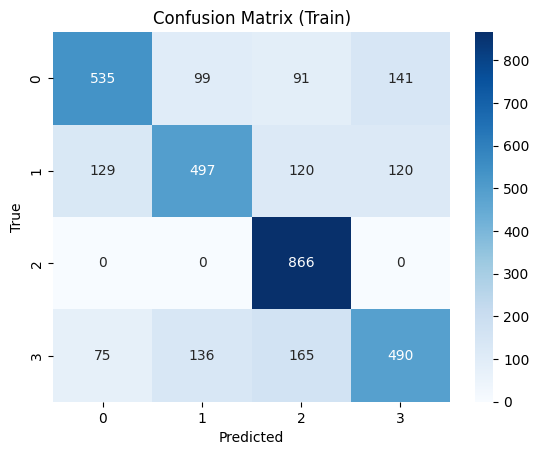


 SVM 70-30 SMOTE (Test)
Accuracy: 0.6386861313868614
Precision: 0.6573598184034591
Recall: 0.6386861313868614
F1 Score: 0.6350775839314733


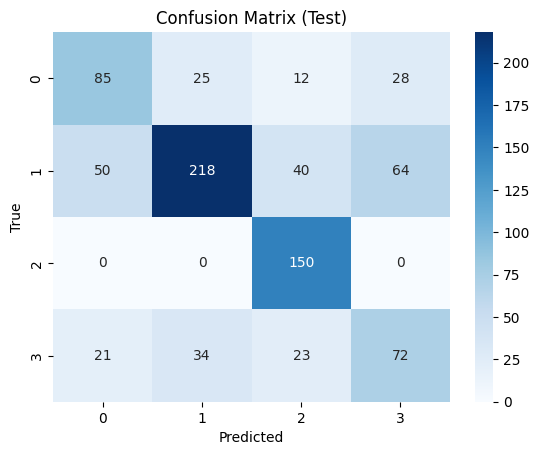


========= Split: 60-40 =========
SVM (Without SMOTE)

 SVM 60-40 No SMOTE (Train)
Accuracy: 0.6699147381242387
Precision: 0.7267261805022324
Recall: 0.6699147381242387
F1 Score: 0.6281503114254029


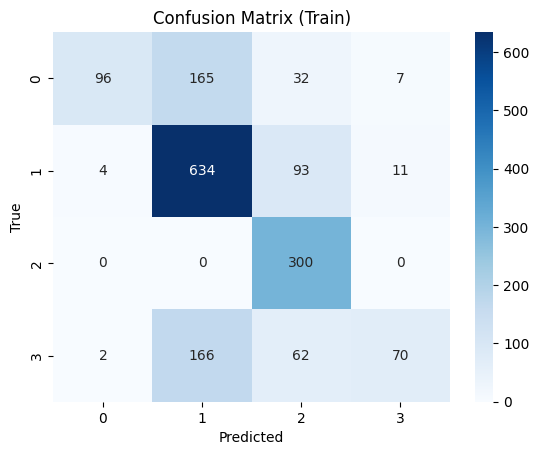


 SVM 60-40 No SMOTE (Test)
Accuracy: 0.6478102189781022
Precision: 0.6747491850345634
Recall: 0.6478102189781022
F1 Score: 0.5917831709712131


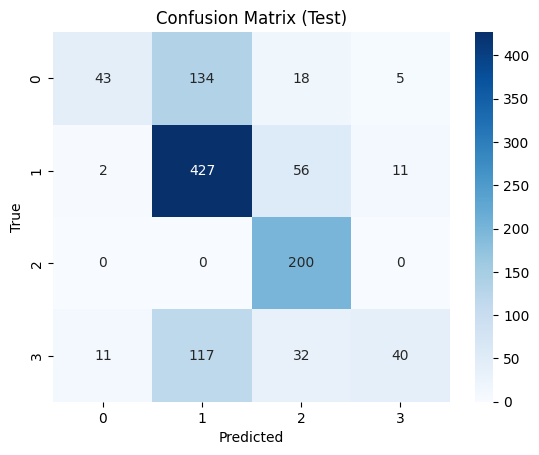

SVM (With SMOTE)

 SVM 60-40 SMOTE (Train)
Accuracy: 0.7008086253369272
Precision: 0.7014286750775788
Recall: 0.7008086253369272
F1 Score: 0.6914054835441102


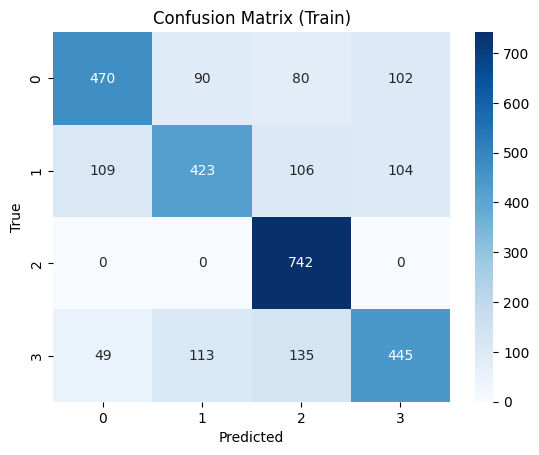


 SVM 60-40 SMOTE (Test)
Accuracy: 0.6240875912408759
Precision: 0.6299471326199536
Recall: 0.6240875912408759
F1 Score: 0.6171238760654643


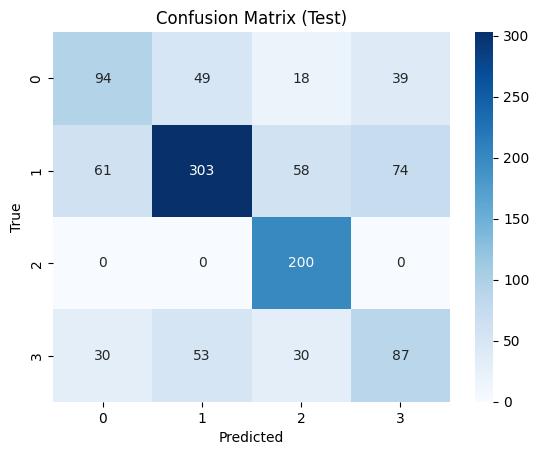

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    def metrics(y_true, y_pred, dataset):
        print(f"\n {title} ({dataset})")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
        print("Recall:", recall_score(y_true, y_pred, average='weighted'))
        print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({dataset})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        if hasattr(model, "decision_function"):
            try:
                precision, recall, _ = precision_recall_curve(y_test, y_score[:,1], pos_label=1)
                plt.plot(recall, precision)
                plt.title(f'Precision-Recall Curve ({dataset})')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.grid()
                plt.show()
            except:
                pass

    metrics(y_train, y_train_pred, "Train")
    metrics(y_test, y_pred, "Test")

# Run across splits
splits = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
for train_size, test_size in splits:
    print(f"\n========= Split: {int(train_size*100)}-{int(test_size*100)} =========")
    X_train, X_test, y_train, y_test = train_test_split(X_compressed, y, test_size=test_size, stratify=y, random_state=42)

    print("SVM (Without SMOTE)")
    model = SVC(kernel='rbf', C=5.0, probability=True)
    evaluate_model(model, X_train, y_train, X_test, y_test, f"SVM {int(train_size*100)}-{int(test_size*100)} No SMOTE")

    print("SVM (With SMOTE)")
    X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
    evaluate_model(model, X_train_sm, y_train_sm, X_test, y_test, f"SVM {int(train_size*100)}-{int(test_size*100)} SMOTE")


In [ ]:
import numpy as np
np.complex = complex  # ✅ Fix librosa compatibility

import librosa
import joblib

# Load saved artifacts
scaler = joblib.load("/content/sample_data/svm_scaler.pkl")
label_encoder = joblib.load("/content/sample_data/svm_label_encoder.pkl")
final_model = joblib.load("/content/sample_data/svm_final_model.pkl")

# Define MFCC extraction
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc.mean(axis=1)  # → shape (13,)


# === Give audio paths directly ===
student_audio = "/content/sample_data/148_s_26.mp3"
teacher_audio = "/content/sample_data/148_t_26.mp3"

student_mfcc = extract_mfcc(student_audio)
teacher_mfcc = extract_mfcc(teacher_audio)

combined = np.concatenate([student_mfcc, teacher_mfcc]).reshape(1, -1)
scaled = scaler.transform(combined)
prediction = final_model.predict(scaled)[0]
label = label_encoder.inverse_transform([prediction])[0]

print(f" Predicted Teacher Response: {label}")


 Predicted Teacher Response: enquiry
